In [ ]:
import os
import glob
import warnings
import h5py as h5
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from copy import deepcopy

from gensit.config import Config
from gensit.inputs import Inputs
from gensit.outputs import Outputs
from gensit.utils.misc_utils import *
from gensit.utils.math_utils import *
from gensit.utils.probability_utils import *
from gensit.contingency_table import instantiate_ct
from gensit.contingency_table.MarkovBasis import instantiate_markov_basis
from gensit.static.plot_variables import LATEX_RC_PARAMETERS, COLOR_NAMES

In [2]:
%matplotlib inline

# AUTO RELOAD EXTERNAL MODULES
%load_ext autoreload
%autoreload 2

In [3]:
# LaTeX font configuration
mpl.rcParams.update(LATEX_RC_PARAMETERS)

In [4]:
# Create new logging object
logger = setup_logger(
    __name__,
    console_level = 'INFO',
    file_level = 'EMPTY'
)

# GeNSIT (Disjoint)

In [ ]:
sample = "table"
reload = True

n_iter = 100000
n_ensemble = 10
seeds = range(1,11)
sigma = 0.1414213562
#0.1414213562, None, 0.0141421356

experiment_id = "NonJointTableSIM_NN_SweepedNoise__totally_and_cell_constrained_20_05_2024_15_57_08"
disjointgensit_out_path = f'../../data/outputs/DC/exp1/{experiment_id}/stored_results/'
makedir(disjointgensit_out_path)

In [ ]:
sigma_str = str(np.round(sigma,5) if sigma is not None else None)
if sample == "intensity":
    settings = {
        "logging_mode": "INFO",
        "coordinate_slice": [
            f"da.sigma=={sigma_str}"
        ],
        "slice":True,
        "metadata_keys":[],
        "burnin_thinning_trimming": [],#{'iter': {"burnin":10000, "thinning":1, "trimming":100000}}
        "sample":[sample],
        "group_by":[],
        "filename_ending":"test",
        "force_reload":False,
        "n_workers": 1
    }
        
    disjointgensit_intensity_mean_path = os.path.join(disjointgensit_out_path,f'disjoint_gensit_{sample}_mean_E{n_ensemble}_N{n_iter}_sigma{sigma_str}.nc')
    if (not os.path.exists(disjointgensit_intensity_mean_path) or reload):
        # Initialise outputs
        disjointgensit_outputs = Outputs(
            config = f'../../data/outputs/DC/exp1/{experiment_id}/config.json',
            settings = settings,
            inputs = None,
            slice = True,
            level = 'NOTE'
        )
        # Silence outputs
        disjointgensit_outputs.logger.setLevels(console_level='NOTE')
        # Load all data
        disjointgensit_outputs.load()

        # Get data from first sweep of the experiment
        disjointgensit_outputs = disjointgensit_outputs.get(0)

        # Compute 
        disjointgensit_intensity_means = []
        for s in tqdm(disjointgensit_outputs.data.alpha.coords['seed'].values):
            disjointgensit_outputs_group = disjointgensit_outputs.select('seed',s)
            disjointgensit_intensity_group = disjointgensit_outputs_group.get_sample('intensity')
            disjointgensit_intensity_means.append(disjointgensit_intensity_group.mean(['iter'],dtype='float64'))
        disjointgensit_intensity_mean = xr.concat(
            disjointgensit_intensity_means, 
            dim='seed',
            coords=disjointgensit_outputs.data.alpha.coords['seed'].values
        ).reset_index('sweep')
        disjointgensit_intensity_mean.to_netcdf(path=disjointgensit_intensity_mean_path)
    elif os.path.exists(disjointgensit_intensity_mean_path):
        print('Loaded',disjointgensit_intensity_mean_path)
        disjointgensit_intensity_mean = xr.open_dataarray(disjointgensit_intensity_mean_path)

else:

    settings = {
        "logging_mode": "INFO",
        "coordinate_slice": [],
        "slice":False,
        "metadata_keys":[],
        "burnin_thinning_trimming": [],#{'iter': {"burnin":10000, "thinning":1, "trimming":100000}}
        "sample":[sample],
        "group_by":[],
        "filename_ending":"test",
        "force_reload":True,
        "n_workers": 1
    }
    disjointgensit_table_mean_path = os.path.join(disjointgensit_out_path,f'disjoint_gensit_{sample}_mean_E{n_ensemble}_N{n_iter}_sigma{sigma_str}.nc')

    if (not os.path.exists(disjointgensit_table_mean_path) or reload):
        disjointgensit_table_means = []
        for seed in tqdm(seeds):
            # Initialise outputs
            disjointgensit_outputs = Outputs(
                config = f'../../data/outputs/DC/exp1/{experiment_id}/config.json',
                settings = settings,
                inputs = None,
                slice = True,
                level = 'NOTE'
            )
            # Silence outputs
            disjointgensit_outputs.logger.setLevels(console_level='NOTE')
            # Slice sweep configurations
            print(disjointgensit_outputs.config.sweep_configurations)
            disjointgensit_outputs.config.sweep_configurations = [(seed,sigma, ['alpha', 'beta'])]
            # Load all data
            disjointgensit_outputs.load()

            # Get data from first sweep of the experiment
            disjointgensit_outputs = disjointgensit_outputs.get(0)
            
            # Compute mean and add it to list
            disjointgensit_table_means.append(disjointgensit_outputs.data.table.mean(['iter'],dtype='float64'))

        # Compute mean across seeds
        disjointgensit_table_mean = xr.concat(
            disjointgensit_table_means, 
            dim='seed'
        ).reset_index('sweep')
        disjointgensit_table_mean.to_netcdf(path=disjointgensit_table_mean_path)

    elif os.path.exists(disjointgensit_table_mean_path):
        print('Loaded',disjointgensit_table_mean_path)
        disjointgensit_table_mean = xr.open_dataset(disjointgensit_table_mean_path)

In [ ]:
inputs = Inputs(
    config = disjointgensit_outputs.config,
    synthetic_data = False,
    logger = disjointgensit_outputs.logger
)
inputs.cast_to_xarray()
ground_truth_table = inputs.data.ground_truth_table

In [ ]:
if 'disjointgensit_table_mean' in globals():
    disjointgensit_table_srmses = disjointgensit_table_mean.groupby('seed').map(
        srmse,
        ground_truth = inputs.data.ground_truth_table,
        mask = inputs.data.test_cells_mask
    ).values
if 'disjointgensit_intensity_mean' in globals():
    disjointgensit_intensity_srmses = disjointgensit_intensity_mean.groupby('seed').map(
        srmse,
        ground_truth = inputs.data.ground_truth_table,
        mask = inputs.data.test_cells_mask
    ).values

# GeNSIT (Joint)

In [5]:
sample = "table"
reload = False

n_iter = 100000
n_ensemble = 1
seeds = None#range(1,n_ensemble+1)
sigma = 0.1414213562
#0.1414213562, None, 0.0141421356

experiment_id = 'JointTableSIM_NN_SweepedNoise__totally_and_cell_constrained_21_05_2024_13_25_40'
jointgensit_out_path = f'../../data/outputs/DC/exp1/{experiment_id}/stored_results/'
makedir(jointgensit_out_path)

In [6]:
sigma_str = str(np.round(sigma,5) if sigma is not None else None)
if sample == "intensity":
    settings = {
        "logging_mode": "INFO",
        "coordinate_slice": [
            f"da.sigma=={sigma_str}"
        ],
        "slice":True,
        "metadata_keys":[],
        "burnin_thinning_trimming": [],#{'iter': {"burnin":10000, "thinning":1, "trimming":100000}}
        "sample":[sample],
        "group_by":[],
        "filename_ending":"test",
        "force_reload":False,
        "n_workers": 1
    }

    jointgensit_intensity_mean_path = os.path.join(jointgensit_out_path,f'joint_gensit_{sample}_mean_E{n_ensemble}_N{n_iter}_sigma{sigma_str}.nc')
    if (not os.path.exists(jointgensit_intensity_mean_path) or reload):
        # Initialise outputs
        jointgensit_outputs = Outputs(
            config = f'../../data/outputs/DC/exp1/{experiment_id}/config.json',
            settings = settings,
            inputs = None,
            slice = True,
            level = 'NOTE'
        )
        # Silence outputs
        jointgensit_outputs.logger.setLevels(console_level='NOTE')
        # Load all data
        jointgensit_outputs.load()

        # Get data from first sweep of the experiment
        jointgensit_outputs = jointgensit_outputs.get(0)

        # Compute 
        jointgensit_intensity_means = []
        for s in tqdm(jointgensit_outputs.data.alpha.coords['seed'].values):
            jointgensit_outputs_group = jointgensit_outputs.select('seed',s)
            jointgensit_intensity_group = jointgensit_outputs_group.get_sample('intensity')
            jointgensit_intensity_means.append(jointgensit_intensity_group.mean(['iter'],dtype='float64'))
        jointgensit_intensity_mean = xr.concat(
            jointgensit_intensity_means, 
            dim='seed',
            coords=jointgensit_outputs.data.alpha.coords['seed'].values
        ).reset_index('sweep')
        jointgensit_intensity_mean.to_netcdf(path=jointgensit_intensity_mean_path)
    elif os.path.exists(jointgensit_intensity_mean_path):
        print('Loaded',jointgensit_intensity_mean_path)
        jointgensit_intensity_mean = xr.open_dataarray(jointgensit_intensity_mean_path)

else:

    settings = {
        "logging_mode": "INFO",
        "coordinate_slice": [],
        "slice":False,
        "metadata_keys":[],
        "burnin_thinning_trimming": [],#{'iter': {"burnin":10000, "thinning":1, "trimming":100000}}
        "sample":[sample],
        "group_by":[],
        "filename_ending":"test",
        "force_reload":True,
        "n_workers": 1
    }
    jointgensit_table_mean_path = os.path.join(jointgensit_out_path,f'joint_gensit_{sample}_mean_E{n_ensemble}_N{n_iter}_sigma{sigma_str}.nc')

    if (not os.path.exists(jointgensit_table_mean_path) or reload):
        jointgensit_table_means = []
        if seeds is not None:
            for seed in tqdm(seeds):
                # Initialise outputs
                jointgensit_outputs = Outputs(
                    config = f'../../data/outputs/DC/exp1/{experiment_id}/config.json',
                    settings = settings,
                    inputs = None,
                    slice = True,
                    level = 'NOTE'
                )
                # Silence outputs
                jointgensit_outputs.logger.setLevels(console_level='NOTE')
                # Slice sweep configurations
                print(jointgensit_outputs.config.sweep_configurations)
                jointgensit_outputs.config.sweep_configurations = [(seed,sigma, ['alpha', 'beta'])]
                # Load all data
                jointgensit_outputs.load()

                # Get data from first sweep of the experiment
                jointgensit_outputs = jointgensit_outputs.get(0)
                
                # Compute mean and add it to list
                jointgensit_table_means.append(jointgensit_outputs.data.table.mean(['iter'],dtype='float64'))

            # Compute mean across seeds
            jointgensit_table_mean = xr.concat(
                jointgensit_table_means, 
                dim='seed'
            ).reset_index('sweep')
            jointgensit_table_mean.to_netcdf(path=jointgensit_table_mean_path)
        else:
            settings = {
                "logging_mode": "INFO",
                "coordinate_slice": [
                    "da.loss_name==str(['dest_attraction_ts_likelihood_loss', 'table_likelihood_loss'])",
                    f"da.sigma=={sigma_str}"
                ],
                "slice":True,
                "metadata_keys":[],
                "burnin_thinning_trimming": [],#{'iter': {"burnin":10000, "thinning":1, "trimming":100000}}
                "sample":[sample],
                "group_by":[],
                "filename_ending":"test",
                "force_reload":False,
                "n_workers": 1
            }
            # Initialise outputs
            jointgensit_outputs = Outputs(
                config = f'../../data/outputs/DC/exp1/{experiment_id}/config.json',
                settings = settings,
                inputs = None,
                slice = True,
                level = 'NOTE'
            )
            # Silence outputs
            jointgensit_outputs.logger.setLevels(console_level='NOTE')
            # Load all data
            jointgensit_outputs.load()

            # Get data from first sweep of the experiment
            jointgensit_outputs = jointgensit_outputs.get(0)

            jointgensit_table = jointgensit_outputs.data.table.squeeze('sweep')
            new_n_seed = 10
            new_n_iter = 10000
            jointgensit_table_reshaped = jointgensit_table.values.reshape((new_n_seed,new_n_iter,jointgensit_table.sizes['origin'],jointgensit_table.sizes['destination']))
            jointgensit_table_reshaped = xr.DataArray(
                data = jointgensit_table_reshaped,
                dims=["seed", "iter", "origin", "destination"],
                coords={
                    "seed": np.arange(1, new_n_seed+1),
                    "iter": np.arange(1, new_n_iter+1),
                    "origin": np.arange(1, 180),
                    "destination": np.arange(1, 180),
                },
                attrs = jointgensit_table.attrs
            )
            jointgensit_table_mean = jointgensit_table_reshaped.mean(['iter'],dtype='float64')
            


    elif os.path.exists(jointgensit_table_mean_path):
        print('Loaded',jointgensit_table_mean_path)
        jointgensit_table_mean = xr.open_dataset(jointgensit_table_mean_path)

15:22.178 config INFO ----------------------------------------------------------------------------------
15:22.193 config INFO Parameter space size: 
 --- sigma: ['sigma', 'to_learn'] (3)
 --- loss_name: ['loss_name', 'loss_function', 'loss_kwargs'] (2)
15:22.207 config INFO Total = 6.
15:22.222 config INFO ----------------------------------------------------------------------------------
15:22.290 outputs INFO //////////////////////////////////////////////////////////////////////////////////
15:22.305 outputs INFO Slicing coordinates:
15:22.320 outputs INFO loss_name==str(['dest_attraction_ts_likelihood_loss', 'table_likelihood_loss'])
15:22.335 outputs INFO sigma==0.14142
15:22.350 outputs INFO //////////////////////////////////////////////////////////////////////////////////
15:22.365 outputs WARNING Removing ../../data/outputs/DC/exp1/JointTableSIM_NN_SweepedNoise__totally_and_cell_constrained_21_05_2024_13_25_40/sample_collections
15:22.379 outputs INFO Collecting samples table.
1

In [7]:
inputs = Inputs(
    config = jointgensit_outputs.config,
    synthetic_data = False,
    logger = jointgensit_outputs.logger
)
inputs.cast_to_xarray()
ground_truth_table = inputs.data.ground_truth_table

21:05.118 inputs NOTE Loading Harris Wilson data ...
21:05.223 inputs NOTE Margins not provided
21:05.238 inputs NOTE Cells subset values file not provided


In [8]:
if 'jointgensit_table_mean' in globals():
    jointgensit_table_srmses = jointgensit_table_mean.groupby('seed').map(
        srmse,
        ground_truth = inputs.data.ground_truth_table,
        mask = inputs.data.test_cells_mask
    ).values

    joint_gensit_table_relative_colsum_l1_error = mean_absolute_residual_percentage_error(
        prediction=jointgensit_table_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
        dim='origin'
    ).values.squeeze()
    joint_gensit_table_relative_rowsum_l1_error = mean_absolute_residual_percentage_error(
        prediction=jointgensit_table_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
        dim='destination'
    ).values.squeeze()

if 'jointgensit_intensity_mean' in globals():
    jointgensit_intensity_srmses = jointgensit_intensity_mean.groupby('seed').map(
        srmse,
        ground_truth = inputs.data.ground_truth_table,
        mask = inputs.data.test_cells_mask
    ).values

    joint_gensit_intensity_relative_colsum_l1_error = mean_absolute_residual_percentage_error(
        prediction=jointgensit_intensity_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
        dim='origin'
    ).values.squeeze()
    joint_gensit_intensity_relative_rowsum_l1_error = mean_absolute_residual_percentage_error(
        prediction=jointgensit_intensity_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
        dim='destination'
    ).values.squeeze()

In [9]:
min(joint_gensit_table_relative_colsum_l1_error),max(joint_gensit_table_relative_colsum_l1_error),sum(joint_gensit_table_relative_colsum_l1_error)

(0.08488749042145591, 17.81973, 222.97024640745695)

# SIM_NN

In [ ]:
reload = False

n_iter = 100000
n_ensemble = 10
seeds = range(1,11)
sigma = 0.1414213562
#0.1414213562, None, 0.0141421356

experiment_id = 'SIM_NN_SweepedNoise__totally_and_cell_constrained_20_05_2024_15_59_08'
sim_nn_out_path = f'../../data/outputs/DC/exp1/{experiment_id}/stored_results/'
makedir(sim_nn_out_path)

In [ ]:
sigma_str = str(np.round(sigma,5) if sigma is not None else None)
settings = {
    "logging_mode": "INFO",
    "coordinate_slice": [
        f"da.sigma=={sigma_str}"
    ],
    "slice":True,
    "metadata_keys":[],
    "burnin_thinning_trimming": [],#{'iter': {"burnin":10000, "thinning":1, "trimming":100000}}
    "sample":["intensity"],
    "group_by":[],
    "filename_ending":"test",
    "force_reload":False,
    "n_workers": 1
}
    
sim_nn_intensity_mean_path = os.path.join(sim_nn_out_path,f'sim_nn_intensity_mean_E{n_ensemble}_N{n_iter}_sigma{sigma_str}.nc')
if (not os.path.exists(sim_nn_intensity_mean_path) or reload):
    # Initialise outputs
    sim_nn_outputs = Outputs(
        config = f'../../data/outputs/DC/exp1/{experiment_id}/config.json',
        settings = settings,
        inputs = None,
        slice = True,
        level = 'NOTE'
    )
    # Silence outputs
    sim_nn_outputs.logger.setLevels(console_level='NOTE')
    # Load all data
    sim_nn_outputs.load()

    # Get data from first sweep of the experiment
    sim_nn_outputs = sim_nn_outputs.get(0)

    # Compute 
    sim_nn_intensity_means = []
    for s in tqdm(sim_nn_outputs.data.alpha.coords['seed'].values):
        sim_nn_outputs_group = sim_nn_outputs.select('seed',s)
        sim_nn_intensity_group = sim_nn_outputs_group.get_sample('intensity')
        sim_nn_intensity_means.append(sim_nn_intensity_group.mean(['iter'],dtype='float64'))
    sim_nn_intensity_mean = xr.concat(
        sim_nn_intensity_means, 
        dim='seed'
    ).reset_index('sweep')
    sim_nn_intensity_mean.to_netcdf(path=sim_nn_intensity_mean_path)
elif os.path.exists(sim_nn_intensity_mean_path):
    print('Loaded',sim_nn_intensity_mean_path)
    sim_nn_intensity_mean = xr.open_dataarray(sim_nn_intensity_mean_path)

In [ ]:
if 'sim_nn_intensity_mean' in globals():
    sim_nn_intensity_mean_srmses = sim_nn_intensity_mean.groupby('seed').map(
        srmse,
        ground_truth = inputs.data.ground_truth_table,
        mask = inputs.data.test_cells_mask
    ).values

    sim_nn_relative_colsum_l1_error = mean_absolute_residual_percentage_error(
        prediction=sim_nn_intensity_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
        dim='origin'
    ).values.squeeze()
    sim_nn_relative_rowsum_l1_error = mean_absolute_residual_percentage_error(
        prediction=sim_nn_intensity_mean,
        ground_truth=ground_truth_table,
        mask=inputs.data.test_cells_mask,
        dim='destination'
    ).values.squeeze()


In [ ]:
min(sim_nn_relative_colsum_l1_error),max(sim_nn_relative_colsum_l1_error),sum(sim_nn_relative_colsum_l1_error)

# GMEL

In [ ]:
reload = False
n_iter = 10000
n_ensemble = 10 

experiment_id = 'GraphAttentionNetwork_Comparison_UnsetNoise__doubly_and_cell_constrained_all_region_features_16_05_2024_21_06_14'
gmel_out_path = f'../../data/outputs/DC/comparisons/{experiment_id}/stored_results/'
makedir(gmel_out_path)

In [ ]:
gmel_intensity_mean_path = f'../../data/outputs/DC/comparisons/{experiment_id}/stored_results/gmel_intensity_mean_E{n_ensemble}_N{n_iter}.nc'
if not os.path.exists(gmel_intensity_mean_path) or reload:
    gmel_settings = {
        "logging_mode": "INFO",
        "coordinate_slice": [
            # "da.seed==1"
        ],
        "slice":False,
        "metadata_keys":[],
        "burnin_thinning_trimming": [],
        "sample":["intensity"],
        "group_by":[],
        "filename_ending":"test",
        "force_reload":False,
        "n_workers": 1
    }

    # Initialise outputs
    gmel_outputs = Outputs(
        config = f'../../data/outputs/DC/comparisons/{experiment_id}/config.json',
        settings = gmel_settings,
        inputs = None,
        slice = True,
        level = 'NOTE'
    )
    # Silence outputs
    gmel_outputs.logger.setLevels(console_level='NOTE')
    # Load all data
    gmel_outputs.load()

    # Get data from first sweep of the experiment
    gmel_outputs = gmel_outputs.get(0)

    makedir(os.path.dirname(gmel_intensity_mean_path))
    gmel_intensity_mean = gmel_outputs.data.intensity.mean(['iter'],dtype='float64')
    gmel_intensity_mean.to_netcdf(path=gmel_intensity_mean_path)
else:
    gmel_intensity_mean = xr.open_dataset(gmel_intensity_mean_path)

In [19]:
inputs = Inputs(
    config = gmel_outputs.config,
    synthetic_data = False,
    logger = gmel_outputs.logger
)
inputs.cast_to_xarray()
ground_truth_table = inputs.data.ground_truth_table

24:11.383 inputs NOTE Loading Harris Wilson data ...
24:11.490 inputs NOTE Margins not provided
24:11.505 inputs NOTE Cells subset values file not provided


In [20]:
if 'gmel_intensity_mean' in globals():
    gmel_srmses = gmel_intensity_mean.groupby('seed').apply(
        srmse,
        ground_truth = inputs.data.ground_truth_table,
        mask = inputs.data.test_cells_mask
    ).__xarray_dataarray_variable__.values

In [22]:
gmel_relative_colsum_l1_error = mean_absolute_residual_percentage_error(
    prediction=gmel_intensity_mean,
    ground_truth=ground_truth_table,
    mask=inputs.data.test_cells_mask,
    dim='origin'
).__xarray_dataarray_variable__.values
gmel_relative_rowsum_l1_error = mean_absolute_residual_percentage_error(
    prediction=gmel_intensity_mean,
    ground_truth=ground_truth_table,
    mask=inputs.data.test_cells_mask,
    dim='destination'
).__xarray_dataarray_variable__.values


In [23]:
min(gmel_relative_colsum_l1_error),max(gmel_relative_colsum_l1_error),sum(gmel_relative_colsum_l1_error)

(0.1993185163816306, 1.1839352152828058, 23.03026892970707)

# GMEL vs GeNSIT (Joint) Statistical significance

In [ ]:
disjointgensit_table_srmses

In [ ]:
jointgensit_table_srmses

In [ ]:
gmel_srmses

# Plots

In [ ]:
sum_dim = 'origin'

region_geometries = getattr(inputs.data,'region_geometries')

if sum_dim == 'destination':
    gmel_quantity = gmel_relative_rowsum_l1_error
    # sim_nn_quantity = sim_nn_relative_rowsum_l1_error
    joint_gensit_quantity = joint_gensit_table_relative_rowsum_l1_error

    gmel_quantity_with_geometries = pd.merge(
        pd.DataFrame({""}),
        region_geometries[['LOCATIONID','geometry']],
        how = 'left',
        left_on = 'origin',
        right_on = 'LOCATIONID'
    ) 
    # Convert back to geodataframe
    gmel_quantity = gpd.GeoDataFrame(gmel_quantity_with_geometries.drop(columns=['LOCATIONID']))

elif sum_dim == 'origin':
    gmel_quantity = gmel_relative_colsum_l1_error
    # sim_nn_quantity = sim_nn_relative_colsum_l1_error
    joint_gensit_quantity = joint_gensit_table_relative_colsum_l1_error



In [35]:
region_geometries

,GEOID,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,NAME,LSAD,ALAND,AWATER,LOCATIONID,geometry
0,11001000100,11,001,000100,1400000US11001000100,1,CT,1907610,512798,1,"MULTIPOLYGON (((-77.06937 38.90037, -77.06307 ..."
1,11001000201,11,001,000201,1400000US11001000201,2.01,CT,503312,0,2,"MULTIPOLYGON (((-77.07902 38.91268, -77.07310 ..."
2,11001000202,11,001,000202,1400000US11001000202,2.02,CT,776437,428754,3,"MULTIPOLYGON (((-77.07941 38.90564, -77.07831 ..."
3,11001000300,11,001,000300,1400000US11001000300,3,CT,1010802,2334,4,"MULTIPOLYGON (((-77.08227 38.92149, -77.08201 ..."
4,11001000400,11,001,000400,1400000US11001000400,4,CT,1542759,69,5,"MULTIPOLYGON (((-77.07316 38.92305, -77.07319 ..."
...,...,...,...,...,...,...,...,...,...,...,...
174,11001010700,11,001,010700,1400000US11001010700,107,CT,891593,0,175,"MULTIPOLYGON (((-77.04945 38.90263, -77.04748 ..."
175,11001010800,11,001,010800,1400000US11001010800,108,CT,661580,0,176,"MULTIPOLYGON (((-77.05013 38.89957, -77.05012 ..."
176,11001010900,11,001,010900,1400000US11001010900,109,CT,2381119,2935328,177,"MULTIPOLYGON (((-77.03899 38.79277, -77.03894 ..."
177,11001011000,11,001,011000,1400000US11001011000,110,CT,654089,364121,178,"MULTIPOLYGON (((-77.02188 38.87650, -77.02115 ..."


In [29]:
if 'joint_gensit_quantity' in globals():
    print(f"Joint GeNSIT min error: {np.min(joint_gensit_quantity)} max error: {np.max(joint_gensit_quantity)} total error: {np.sum(joint_gensit_quantity)}")
if 'sim_nn_quantity' in globals():
    print(f"SIM NN min error: {np.min(sim_nn_quantity)} max error: {np.max(sim_nn_quantity)} total error: {np.sum(sim_nn_quantity)}")
if 'gmel_quantity' in globals():
    print(f"GMEL min error: {np.min(gmel_quantity)} max error: {np.max(gmel_quantity)} total abs error: {np.sum(gmel_quantity)}")

Joint GeNSIT min error: 0.08488749042145591 max error: 17.81973 total error: 222.97024640745695
GMEL min error: 0.1993185163816306 max error: 1.1839352152828058 total abs error: 23.030268929707074


In [31]:
if 'joint_gensit_quantity' in globals():
    print('Joint GeNSIT lower error locations:',sum([1 if abs(gmel_quantity[i]) >= abs(joint_gensit_quantity[i]) else 0 for i in range(len(gmel_quantity))]))
if 'gmel_quantity' in globals():
    print('GMEL lower error locations:',sum([1 if abs(gmel_quantity[i]) < abs(joint_gensit_quantity[i]) else 0 for i in range(len(gmel_quantity))]))

Joint GeNSIT lower error locations: 6
GMEL lower error locations: 37


In [ ]:
plot_settings = {
    "figure_size":(10,10),
    "colourmap":"RdYlBu_r"
}

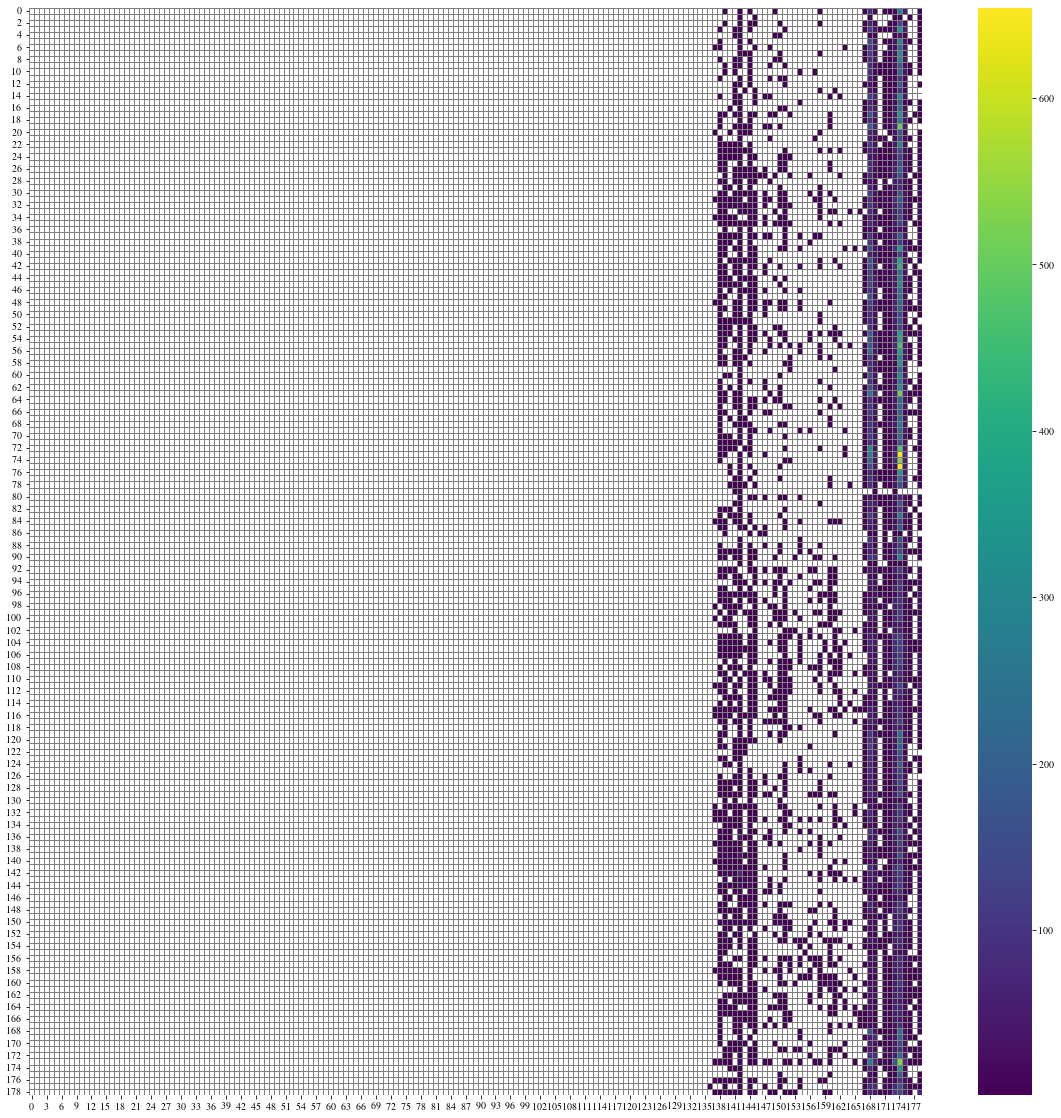

In [ ]:
# Figure size 
fig, ax = plt.subplots(
    figsize = plot_settings.get('figure_size',None),
    ncols = 1,
    nrows = 1,
    squeeze = False
)

# Set colormap
cmap = plt.get_cmap(plot_settings.get('colourmap',None))

# Global axes label
for var in ['x','y']:
    if plot_settings.get(f'{var}_label',''):
        axis_label = plot_settings[f'{var}_label'].replace("_"," ")
        getattr(plt,f"{var}label",plt.xlabel)(
            axis_label,
            fontsize = plot_settings.get(f'{var}_label_size',None),
            labelpad = plot_settings.get(f'{var}_label_pad',None),
            rotation = plot_settings.get(f'{var}_label_rotation',None)
        )
        print(f"{var}_tick_size",plot_settings.get(f"{var}_tick_size",[None]))
        ax.tick_params(
            axis = var, 
            pad = plot_settings.get(f"{var}_tick_pad",[None])[0],
            bottom = True,
            labelsize = plot_settings.get(f"{var}_tick_size",[None])[0],
            rotation = plot_settings.get(f"{var}_tick_rotation",[None])[0]
        )
        ax = kwargs['x'].plot(
                column = 'data',
                ax = ax,
                alpha = kwargs.get('alpha',None),
                markersize = kwargs.get('s',None),
                cmap = self.cmap,
                # norm = mcolors.SymLogNorm(vmin=vmin, linthresh=1.0, vmax=vmax), 
                norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax),
                edgecolor = ('black',0.8),
                legend = self.settings['colourbar'],
                # legend_kwds = dict(
                #     ticks = mpl.ticker.FixedLocator(list(np.linspace(vmin,0,5,False))+list(np.linspace(0,vmax,5,False)))
                # )
            )
        ax.tick_params(labelsize=self.settings['x_tick_size'][0])
            if len(ax.get_figure().get_axes()) > 1:
                # Access the colorbar
                cbar = ax.get_figure().get_axes()[1]
                # Set the fontsize of the colorbar
                cbar.tick_params(labelsize=self.settings['x_tick_size'][0])
        

# Colourbar

In [ ]:
import matplotlib.colors as mcolors

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15,20))

# Remove axis visibility
ax.set_visible(False)

# Add the colorbar
cbar = fig.colorbar(
    plt.cm.ScalarMappable(
        cmap = 'bwr_r',
        norm = mcolors.TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1.0)
    ),
    ax=ax,
    orientation='horizontal'
)

cbar.ax.tick_params(labelsize=16)

write_figure(
    figure=fig,
    filepath="../../data/outputs/DC/exp1/paper_figures/colourbar/spatial_residual_colourbar",
    figure_format="pdf"
)